In [5]:
%load_ext autoreload
%autoreload 2 
from vpot.calc import myMolecule
from vpot.calc.grids import sphericalGrid, blockGrid, pointGrid,sphericalAtomicGrid,blockAtomicGrid
from vpot.calc.potential import vpot,vBpot, vpotANC
from vpot.calc import DFTGroundState
from matplotlib import pyplot as plt
from scipy.special import erf
from scipy.optimize import minimize
from vpot.calc.grids import sphericalAtomicGrid
from psi4.driver import qcdb

import psi4
import numpy as np
import logging,time

plt.style.use("dark_background")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def getCoeffsAndExps(basisDict,atomType):
    out = []
    for i in basisDict["shell_map"]:
        if i[0] == atomType:
            for j in i[2:]:
                for k in j[1:]:
                    out.append(k)
    return(out)
    
    

def optmizeBasis(x0,Gs,atomType):
    optmizeBasis.counter+=1
    xmod = x0
    counter = 0
    a,basDict =   qcdb.BasisSet.pyconstruct(mol.to_dict(),'BASIS',
                                                     "def2-TZVP",fitrole='ORBITAL',
                                                     other=None,return_dict=True,return_atomlist=False)
    
    a,newBasis = qcdb.BasisSet.pyconstruct(Gs.mol.psi4Mol.to_dict(),'BASIS', 
                                           "def2-SVP",fitrole='ORBITAL',
                                          other=None,return_dict=True,return_atomlist=False)

    for i in newBasis["shell_map"]:
        del i[2:]

    for c,i in enumerate(Gs.mol.basisDict["shell_map"]):
        if i[0] == atomType:
            for j in i[2:]:
                newBas = []
                newBas.append(j[0])
                for k in j[1:]:
                    newBas.append((xmod[counter],xmod[counter+1]))
                    counter+=2
                newBasis["shell_map"][c] += [newBas]

    Gs.mol.setBasisDict(newBasis,quiet=True)
    logging.info(getCoeffsAndExps(M.basisDict,atomType))

    Gs.projectBasis()
    Vs = Gs.optimizeBasis(potentialType="anc",a=2)
    Error = Gs.getMSError(Vs)

    logging.info(f"ERROR FROM AUGMENTBASIS: {Error}")
    logging.info(getCoeffsAndExps(M.basisDict,atomType))

    if (optmizeBasis.counter %1000)==0:
        print(f"Count: {optmizeBasis.counter}, Error {Error}")
    return Error


GridInfo : {'type': 'block', 'minDist': 0.01, 'nPoints': 113105, 'block': {'xmin': -12.707764991420921, 'xmax': -2.659793996434461, 'ymin': -3.173531660374667, 'ymax': 6.130295422024509, 'zmin': -4.907442307883995, 'zmax': 4.351677633839099}, 'xdim': 101, 'ydim': 94, 'zdim': 93} 
residue  : 48.608341513983746
MeanError: 0.00042976297700352543
MaxError : 0.0909819021325534
MinError : 2.546348114886593e-14


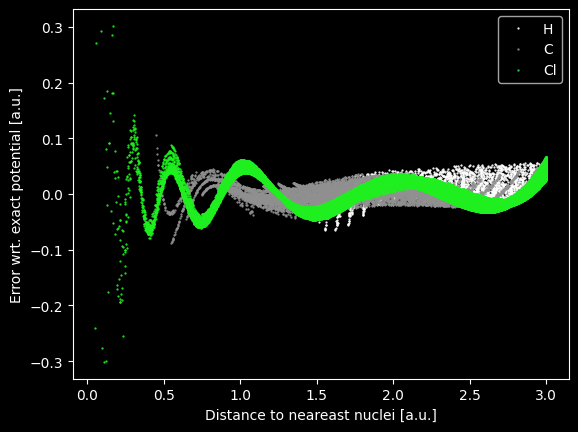

Length of xinit: 45
   => Loading Basis Set <=

    Name: DEF2-TZVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry C          line   123 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 
    atoms 2   entry CL         line   534 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 
    atoms 3-5 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 


Basis is augmented!

Basis set has 95 functions


{'message': '   => Loading Basis Set <=\n\n    Name: DEF2-SVP\n    Role: ORBITAL\n    Keyword: BASIS\n    atoms 1   entry C          line    90 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs \n    atoms 2   entry CL         line   356 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs \n    atoms 3-5 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs \n\n',
 'key': 'BASIS',
 'name': 'DEF2-SVP',
 'blend': 'DEF2-SVP',
 'puream': 1,
 'shell_map': [['C', '72db9a94c8f274aebf4410505c2208131fe6a66b'],
  ['CL',
   '3639ab98fc0f5e64dafb43e8b43524c0e027c969',
   [0,
    (237.1128658946826, -34.40928432976986),
    (360.80886759736984, 4.899519290393016),
    (175.50572837925787, 87.09490744382282),
    (189.95138398897666, 77.77639536561747),
    (175.1342229434199, -51.27559117084596),
    (378.29777049694496, 4.079466200169169),
    (545.2014603407004, -8.41727640016857),
    (1381.0434064454464, -6.7972982934302175),
    (171

In [176]:
def optmizeBasis(x0,Gs,atomType):
    optmizeBasis.counter+=1
    xmod = x0
    counter = 0
    
    a,newBasis = qcdb.BasisSet.pyconstruct(Gs.mol.psi4Mol.to_dict(),'BASIS', 
                                           "def2-SVP",fitrole='ORBITAL',
                                          other=None,return_dict=True,return_atomlist=False)

    for i in newBasis["shell_map"]:
        del i[2:]

    for c,i in enumerate(Gs.mol.augmentDict["shell_map"]):
        if i[0] == atomType:
            for j in i[2:]:
                newBas = []
                newBas.append(j[0])
                for k in j[1:]:
                    newBas.append((xmod[counter],xmod[counter+1]))
                    counter+=2
                newBasis["shell_map"][c] += [newBas]

    Gs.mol.setBasisDict(orbitalDict=Gs.mol.getOrbitalDict(),augmentDict=newBasis,quiet=True)
    logging.info(getCoeffsAndExps(M.basisDict,atomType))

    Gs.projectBasis()
    Vs = Gs.optimizeBasis(potentialType="anc",a=2)
    Error = Gs.getMSError(Vs)

    logging.info(f"ERROR FROM AUGMENTBASIS: {Error}")
    logging.info(getCoeffsAndExps(M.basisDict,atomType))

    if (optmizeBasis.counter %1000)==0:
        print(f"Count: {optmizeBasis.counter}, Error {Error}")
    return Error




atomType = "CL"
#M = myMolecule("tests/CH3Cl.xyz","def2-TZVP")
Gb = blockAtomicGrid(M,atomType,minDist=0.01,maxDist=3.0,gridSpacing=0.1) 
Vb = Gb.optimizeBasis(potentialType="anc",a=2)
Gb.printStats(Vb,output="print")
Gb.exportErrorVsDistance(Vb)

M.keepAugmentBasisForAtomType("CL")

xdim = M.getAngmomAndContraction()

length = sum(xdim[atomType]["Contraction"])

print(f"Length of xinit: {length}")

xinit = np.array(getCoeffsAndExps(M.getAugmentDict(),atomType))
xinit = xinit.flatten()

bounds = [(0.1,100000.0) if (c%2==0) else (None,None) for c,x in enumerate(xinit) ]

optmizeBasis.counter=0
result = minimize(optmizeBasis,xinit,args=(Gb,atomType),bounds=bounds)
result
M.augmentDict


In [180]:
result

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.00042976297700352543
        x: [ 2.371e+02 -3.441e+01 ...  1.946e+02 -9.831e+00]
      nit: 0
      jac: [ 2.149e-07  5.747e-08 ... -2.239e-09  5.880e-08]
     nfev: 91
     njev: 1
 hess_inv: <90x90 LbfgsInvHessProduct with dtype=float64>

   => Loading Basis Set <=

    Name: DEF2-QZVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry CL         line   809 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-qzvp.gbs 


Basis is augmented!

Basis set has 79 functions
GridInfo : {'type': 'block', 'minDist': 0.01, 'nPoints': 112963, 'block': {'xmin': -3.0, 'xmax': 3.0, 'ymin': -3.0, 'ymax': 3.0, 'zmin': -3.0, 'zmax': 3.0}, 'xdim': 60, 'ydim': 60, 'zdim': 60} 
residue  : 66.76377477281633
MeanError: 0.0005910233861779196
MaxError : 2.126587047734469
MinError : 4.247038684218814e-12


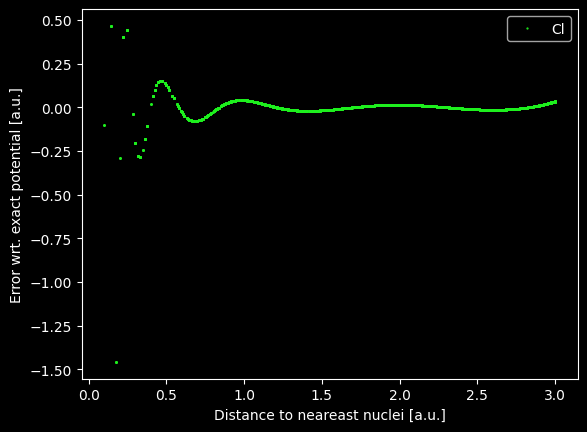

In [161]:
M = myMolecule("tests/Cl.xyz","def2-QZVP")
Gb = blockAtomicGrid(M,atomType,minDist=0.01,maxDist=3.0,gridSpacing=0.1) 
Vb = Gb.optimizeBasis(potentialType="anc",a=2)
Gb.printStats(Vb,output="print")
Gb.exportErrorVsDistance(Vb)

   => Loading Basis Set <=

    Name: DEF2-TZVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry CL         line   534 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 


Basis is augmented!

Basis set has 46 functions
GridInfo : {'type': 'block', 'minDist': 0.01, 'nPoints': 112963, 'block': {'xmin': -3.0, 'xmax': 3.0, 'ymin': -3.0, 'ymax': 3.0, 'zmin': -3.0, 'zmax': 3.0}, 'xdim': 60, 'ydim': 60, 'zdim': 60} 
residue  : 36069.88346999533
MeanError: 0.3193070604533815
MaxError : 5.434025411536326
MinError : 7.666268359087583e-10


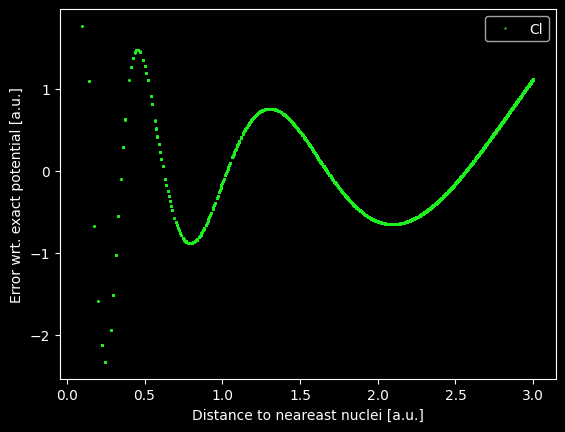

   => Loading Basis Set <=

    Name: DEF2-TZVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry CL         line   534 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 


Basis is augmented!

Basis set has 46 functions


In [155]:
M = myMolecule("tests/Cl.xyz","def2-TZVP")
Gb = blockAtomicGrid(M,atomType,minDist=0.01,maxDist=3.0,gridSpacing=0.1) 
Vb = Gb.optimizeBasis(potentialType="anc",a=2)
Gb.printStats(Vb,output="print")
Gb.exportErrorVsDistance(Vb)

M.keepAugmentBasisForAtomType("CL")

   => Loading Basis Set <=

    Name: DEF2-TZVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry C          line   123 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 
    atoms 2   entry CL         line   534 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 
    atoms 3-5 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 


Basis is augmented!

Basis set has 122 functions
GridInfo : {'type': 'block', 'minDist': 0.01, 'nPoints': 268053, 'block': {'xmin': -13.707764991420921, 'xmax': -1.6597939964344608, 'ymin': -4.173531660374667, 'ymax': 7.130295422024509, 'zmin': -5.907442307883995, 'zmax': 5.351677633839099}, 'xdim': 121, 'ydim': 114, 'zdim': 113} 
residue  : 22100.01525592714
MeanError: 0.08244643878608761
MaxError : 40.42613180785691
MinError : 1.932786297916199e-13


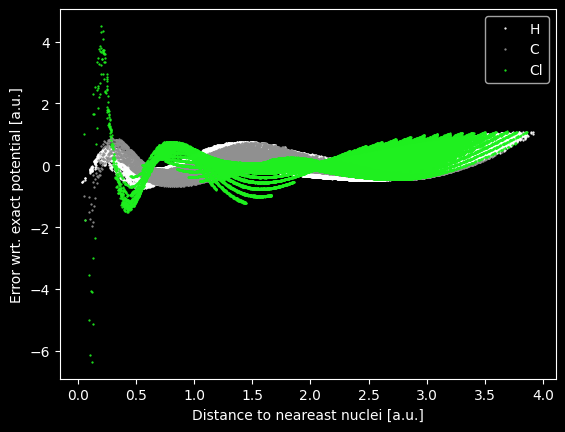

In [190]:
from vpot.calc.basis.augment import Sopt
atomType = "C"
M = myMolecule("tests/CH3Cl.xyz","def2-TZVP")
Gb = blockAtomicGrid(M,atomType,minDist=0.01,maxDist=4.0,gridSpacing=0.1) 
Vb = Gb.optimizeBasis(potentialType="anc",a=2)

Gb.printStats(Vb,output="print")
Gb.exportErrorVsDistance(Vb)

In [129]:
M.getAngmomAndContraction()
        

{'C': {'angMom': [0, 1, 2], 'Contraction': [15, 15, 15]},
 'CL': {'angMom': [], 'Contraction': []},
 'H': {'angMom': [], 'Contraction': []}}

{'C': {'angMom': [0, 1, 2], 'Contraction': [15, 15, 15]},
 'CL': {'angMom': [0, 1, 2], 'Contraction': [10, 10, 10]},
 'H': {'angMom': [0, 2], 'Contraction': [3, 3]}}

False